In [1]:
# standard Python packages for scientific computing:
import numpy as np  # Numerical Python
import matplotlib.pyplot as plt  # plotting
import math as m
import os  # operating system / file utilities
import sys
from timestep import *
from Grid1DCartesian import *
from copy import deepcopy
    
# from numba import jit
# first did "conda install numba".  See
# https://numba.readthedocs.io/en/stable/user/5minguide.html

In [2]:
# default figure size okay if notebook is zoomed for class presentation:
# plt.rcParams["figure.figsize"] = [6.4, 4.8] # default
plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [3]:
# create a subdirectory to hold figures
# (if it doesn't exist already)
os.makedirs("../figs", exist_ok=True)

In [4]:
def init_smooth(N):
    # created the grid
    x = np.linspace(0, 1, N+1)
    x = (x[0:-1] + x[1:]) / 2
    u = np.zeros(np.size(x))
    
    # set initial conditions
    u = 1 * np.exp(- (x-0.5) ** 2 / 0.1 ** 2)
    
    return x, u

In [5]:
def init_step(N):
    # created the grid
    x = np.linspace(0, 1, N+1)
    x = (x[0:-1] + x[1:]) / 2
    u = np.zeros(np.size(x))
    
    # set initial conditions
    u = 1 * np.exp(- (x-0.3) ** 2 / 0.07 ** 2)
    where = np.where(np.abs(x-0.7) <= 0.1)[0]
    u[where] = 1

    return x, u

### Functions for shallow water wave propagation

In [6]:
# make the function name more descriptive and relevant
def find_uL_uR(x, u, bc = 'periodic'):
    alpha = 4
    if bc == 'periodic':
        u1 = (7/12 * (u + np.roll(u, -1))) - (1/12 * (np.roll(u, 1) + np.roll(u, -2)))

        uMPL = u + minmod(np.roll(u, -1) - u, alpha * (u - np.roll(u, 1)))
        uL = median(u1, u, uMPL)
        uMPR = np.roll(u, -1) + minmod(u - np.roll(u, -1), \
                                       alpha * (np.roll(u, -1) - np.roll(u, -2)))
        uR = median(u1, np.roll(u, -1), uMPR)
    else:
        u1 = (7/12 * (u[-1,0] + u[0,1])) - (1/12 * (u[-2,-1] + u[1,2]))
        
        uMPL = u[-1,0] + minmod(u[0,1] - u[-1,0], alpha * (u[-1,0] - u[-2,-1]))
        uL = median(u1, u[-1,0], uMPL)
        uMPR = u[0,1] + minmod(u[-1,0] - u[0,1], alpha * (u[0,1] - u[1,2]))
        uR = median(u1, u[0,1], uMPR)
    
    return uL, uR

In [7]:
def flux_hat(h, u, b, bc = 'periodic'):
    f = np.array([u*h, 1/2*(u**2)+g*(h+b)])
    return f

In [370]:
def flux(x, q, b, bc = 'periodic'):
    if bc == 'periodic':
        q0 = q[0].get_value('grid')
        q1 = q[1].get_value('grid')
        c_abs = np.abs(q1) + np.sqrt(g * q0)
        c_max = maxmax(c_abs, np.roll(c_abs, -1)) * 1.1
    else:
        c_abs = np.abs(q[1]) + (g * q[0]) ** 0.5
        c_max = maxmax(c_abs[0,1], c_abs[-1,0]) * 1.1
    
    if bc == 'periodic':
        bb = b.get_value('grid')
        hL, hR = find_uL_uR(x, q0)
        uL, uR = find_uL_uR(x, q1)
        bL, bR = find_uL_uR(x, bb)
    else:
        hL, hR = find_uL_uR(x, q[0], bc)
        uL, uR = find_uL_uR(x, q[1], bc)
        bL, bR = find_uL_uR(x, b, bc)
    
    f_hatL = flux_hat(hL, uL, bL)
    f_hatR = flux_hat(hR, uR, bR)
    
    f = 1/2 * (f_hatL + f_hatR) - 1/2 * np.abs(c_max) * np.array([hR - hL, uR - uL])
    return f

In [368]:
# advect 1 step
def advect_1step(x, q, b, g, t0, dt, bc = 'periodic'):
    # here assumes uniform grid
    dx = x[1] - x[0]
    
    if bc == 'periodic':
        w0 = q
        f0 = flux(x, w0, b)
        df0 = - f0 + np.roll(f0, 1, axis = 1)
        df0Grid = deepcopy(q)
        df0Grid[0].set_value(df0[0,:], 'all')
        df0Grid[1].set_value(df0[1,:], 'all')
        w1 = w0 + (dt / dx) * df0Grid
        f1 = flux(x, w1, b)
        df1 = - f1 + np.roll(f1, 1, axis = 1)
        df1Grid = deepcopy(q)
        df1Grid[0].set_value(df1[0,:], 'all')
        df1Grid[1].set_value(df1[1,:], 'all')
        w2 = 3/4 * w0 + 1/4 * (w1 + (dt / dx) * df1Grid)
        f2 = flux(x, w2, b)
        df2 = - f2 + np.roll(f2, 1, axis = 1)
        df2Grid = deepcopy(q)
        df2Grid[0].set_value(df2[0,:], 'all')
        df2Grid[1].set_value(df2[1,:], 'all')
        w3 = 1/3 * w0 + 2/3 * (w2 + (dt / dx) * df2Grid)
        q_next = w3
    else:
        w0 = q
        f0 = flux(x, w0, b, bc)
        # flux differentiation
        df0 = - f0[:,1:] + f0[:,0:-1]
        # convert flux differentiation to Grid array of the same shape as q
        nghost = b.get_first_grid()[0]
        pad = np.zeros((2, nghost))
        df0 = np.concatenate((pad, df0, pad), axis = 1)
        df0Grid = deepcopy(q)
        df0Grid[0].set_value(df0[0,:], 'all')
        df0Grid[1].set_value(df0[1,:], 'all')
        # update value
        w1 = w0 + (dt / dx) * df0Grid
        
        f1 = flux(x, w1, b, bc)
        df1 = - f1[:,1:] + f1[:,0:-1]
        # convert flux differentiation to Grid array of the same shape as q
        df1 = np.concatenate((pad, df1, pad), axis = 1)
        df1Grid = deepcopy(q)
        df1Grid[0].set_value(df1[0,:], 'all')
        df1Grid[1].set_value(df1[1,:], 'all')
        # update value
        w2 = 3/4 * w0 + 1/4 * (w1 + (dt / dx) * df1Grid)
        
        f2 = flux(x, w2, b, bc)
        df2 = - f2[:,1:] + f2[:,0:-1]
        # convert flux differentiation to Grid array of the same shape as q
        df2 = np.concatenate((pad, df2, pad), axis = 1)
        df2Grid = deepcopy(q)
        df2Grid[0].set_value(df2[0,:], 'all')
        df2Grid[1].set_value(df2[1,:], 'all')
        # update value
        w3 = 1/3 * w0 + 2/3 * (w2 + (dt / dx) * df2Grid)
        q_next = w3
    
    t = t0 + dt
    
    return q_next, t

## New Run

In [180]:
# gravity acceleration
g = 1
# depth scale
b_0 = -1
# initial velocity
u_0 = 0
# number of grid points
N = 100
# intialization of profile (TODO)
x, eta = init_step(N)
eta = eta * 0.5
# bathymetry elevation relative to MSL
b = np.ones(np.size(x)) * b_0
# water depth (from bottom to water surface)
h = eta - b
# water speed
u = np.ones(np.size(x)) * u_0
# water wave speed
c = np.sqrt(g * h)

# quantity for computation
q = np.array([h, u])
q_init = q

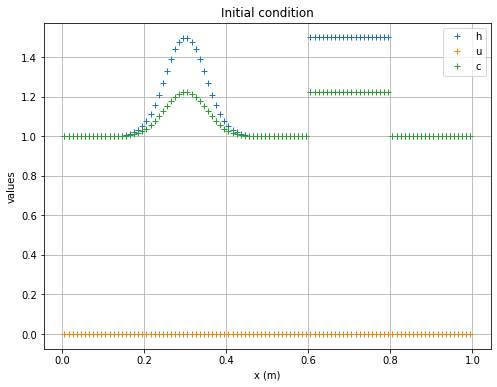

In [181]:
plt.plot(x, q[0,:], '+', label = 'h')
plt.plot(x, q[1,:], '+', label = 'u')
plt.plot(x, c, '+', label = 'c')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('Initial condition')
plt.show()

In [182]:
c_abs = np.abs(q[1,:]) + np.sqrt(g * q[0,:])
c_max = maxmax(c_abs, np.roll(c_abs, -1)) * 1.1

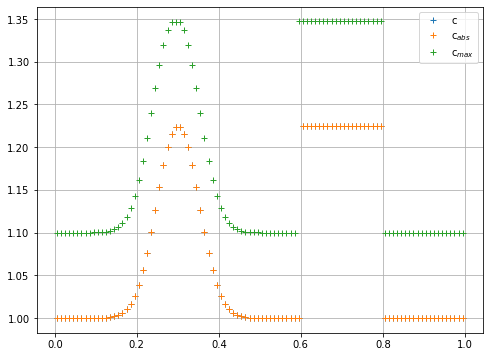

In [183]:
plt.plot(x, c, '+', label = 'c')
plt.plot(x, c_abs, '+', label = 'c$_{abs}$')
plt.plot(x, c_max, '+', label = 'c$_{max}$')
plt.grid()
plt.legend()
plt.show()

In [184]:
hL, hR = find_uL_uR(x, h)
uL, uR = find_uL_uR(x, u)

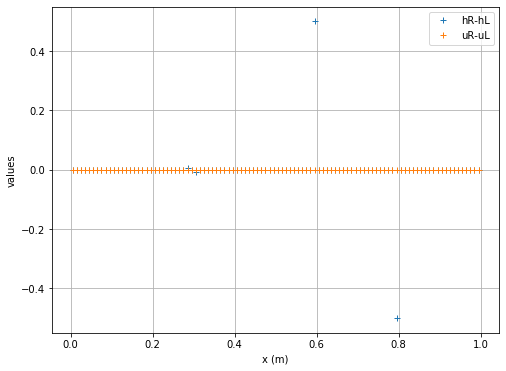

In [185]:
plt.plot(x, hR-hL, '+', label = 'hR-hL')
plt.plot(x, uR-uL, '+', label = 'uR-uL')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

In [186]:
f = flux(x, q, b)

In [187]:
np.shape(f)

(2, 100)

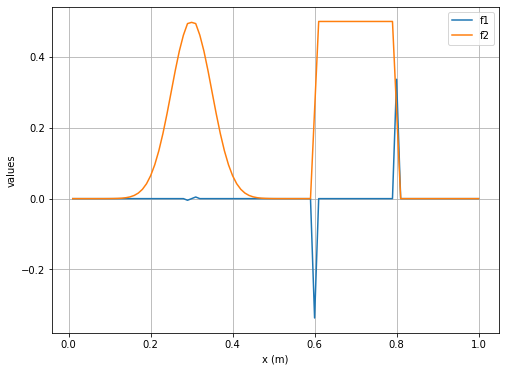

In [188]:
plt.plot(x+(x[1]-x[0])/2, f[0,:], label = 'f1')
plt.plot(x+(x[1]-x[0])/2, f[1,:], label = 'f2')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

In [189]:
t0 = 0
CFL = 0.01
dx = x[1] - x[0]

q = q_init
t = t0

In [190]:
Nsteps = 1000
for ii in range(Nsteps):
    dt = CFL * dx / np.amax(np.abs(q[1,:]) + np.sqrt(g * q[0,:]))
    q, t = advect_1step(x, q, b, g, t, dt, 'periodic')

Text(0.5, 1.0, 't = 0.0743375 s')

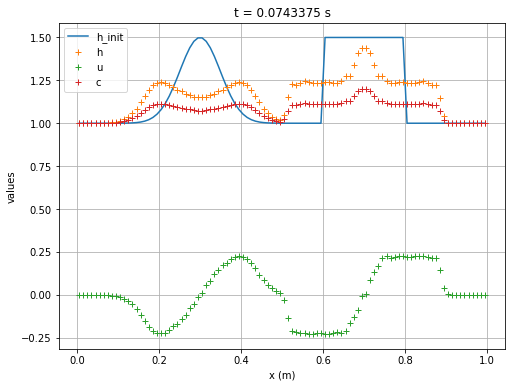

In [191]:
plt.plot(x, q_init[0,:], '-', label = 'h_init')
plt.plot(x, q[0,:], '+', label = 'h')
plt.plot(x, q[1,:], '+', label = 'u')
plt.plot(x, np.sqrt(g * q[0,:]), '+', label = 'c')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('t = %.7f s' % t)
#plt.show()

In [22]:
1/dt

13424.399303877799

In [23]:
dt

7.449122879644514e-05

In [24]:
c_abs = np.abs(q[1,:]) + np.sqrt(g * q[0,:])
c_max = maxmax(c_abs, np.roll(c_abs, -1)) * 1.1

hL, hR = find_uL_uR(x, q[0,:])
uL, uR = find_uL_uR(x, q[1,:])

f_hatL = flux_hat(hL, uL, b)
f_hatR = flux_hat(hR, uR, b)

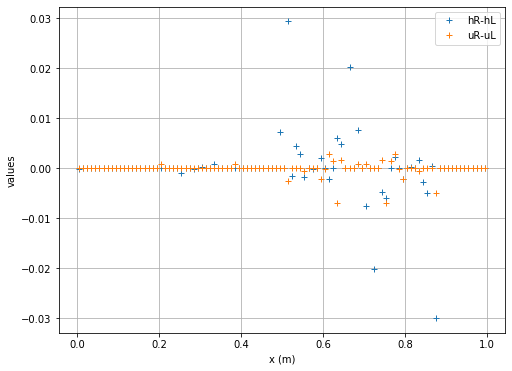

In [25]:
plt.plot(x, hR-hL, '+', label = 'hR-hL')
plt.plot(x, uR-uL, '+', label = 'uR-uL')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

In [26]:
t

0.07433752441327572

In [27]:
np.sum(q_init[0,:])

116.20358847029001

In [28]:
np.sum(q[0,:])

116.20385386740838

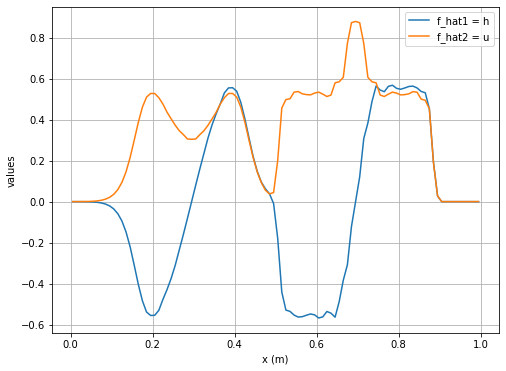

In [29]:
plt.plot(x, f_hatL[0,:] + f_hatR[0,:], label = 'f_hat1 = h')
plt.plot(x, f_hatL[1,:] + f_hatR[1,:], label = 'f_hat2 = u')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

In [30]:
f = flux(x, q, b)

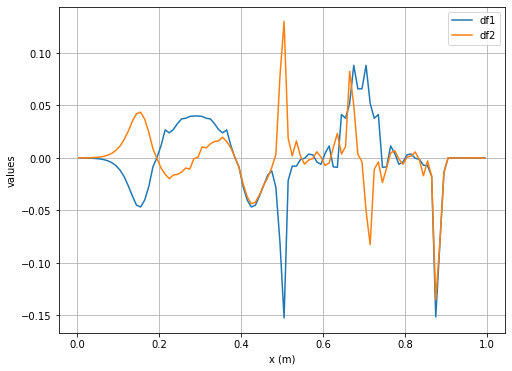

In [31]:
plt.plot(x, np.roll(f,-1)[0,:] - f[0,:], label = 'df1')
plt.plot(x, np.roll(f,-1)[1,:] - f[1,:], label = 'df2')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

## Test on reflecting boundary condition

Use Grid1DCartesian class

In [792]:
# define bathymetry
bGrid = Grid1DCartesian(0,400,4000,2)
x = bGrid.get_grid('all')
C = 0.0001
R = 20.0-C
S = 5
A = R * S / (R - S)
B = S / (R - S)
#b = - C - A * np.exp((x-60)/10) / (1 + B * np.exp((x-60)/10)) - 0.2 * x
b = 0 * 0.5 * np.exp(- (x-100)**2 / 5**2) - 4
where = np.where(x <= 200)[0]
b[where] = -0.2
where = np.where(x <= 120)[0]
b[where] = -0.05
where = np.where(x <= 60)[0]
b[where] = -0.001
#where = np.where(x >= 320)[0]
#b[where] = -0.2
#where = np.where(x >= 370)[0]
#b[where] = -0.005
for ii in range(100000):
    v = [1/4, 1/2, 1/4]
    b = np.convolve(b, v, mode = 'same')
    b[0] = -0.001
    b[-1] = -4
bGrid.set_value(b, 'all')

In [793]:
# define initial sea level
sGrid = Grid1DCartesian(0,400,4000,2)
x = sGrid.get_grid('all')
#s = 0.2 * np.exp(- (x-90)**2 / 5**2)
s = 0 * x
where = np.where(np.abs(x-380) <= 20)[0]
#s[where] = 0.5 * (x[where]-200) * np.exp(-(x[where]-200)**2 / 5**2)
s[where] = 0.001 * np.sin(2*np.pi*(x[where]-380)/40) ** 2
sGrid.set_value(s, 'all')

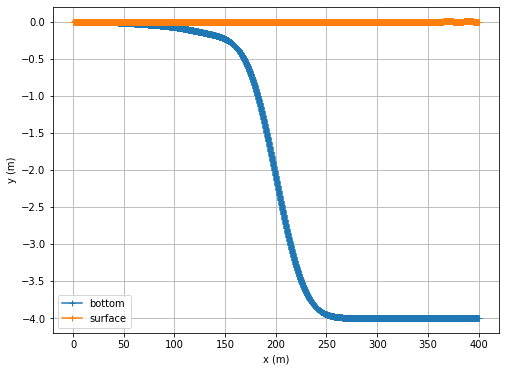

In [794]:
plt.plot(x, b, '+-', label='bottom')
plt.plot(x, s, '+-', label='surface')
plt.grid()
plt.legend()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [795]:
# define water depth
hGrid = sGrid - bGrid
h = hGrid.get_value('all')
#h = maxmax(h, 0.01)
hGrid.set_value(h, 'all')

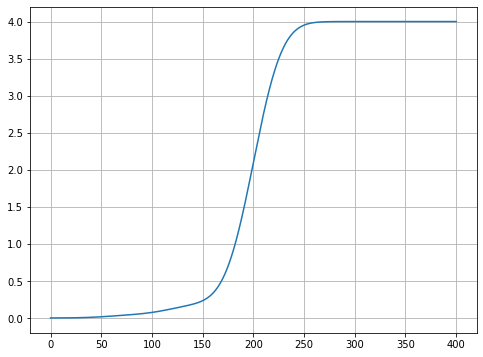

In [796]:
plt.plot(x, hGrid.get_value('all'))
plt.grid()
plt.show()

In [797]:
# define velocity
uGrid = Grid1DCartesian(0,400,4000,2)
u = np.zeros(np.shape(b))
uGrid.set_value(u)

In [798]:
# define momentum
pGrid = hGrid * uGrid

In [804]:
q = np.array([hGrid, uGrid])

g = 0.0098
CFL = 0.1
dx = x[1] - x[0]
t0 = 0
q_init = deepcopy(q)
t = t0
bc = 'nonperiodic'

In [805]:
times = np.arange(300,3601,300)
times

array([ 300,  600,  900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300,
       3600])

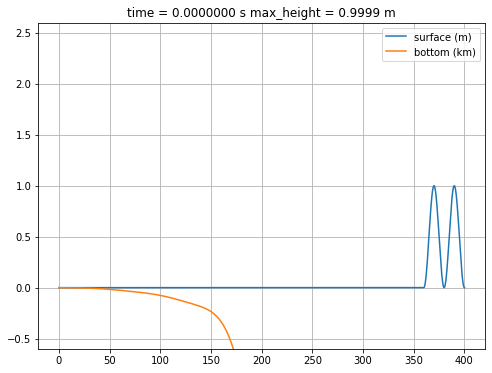

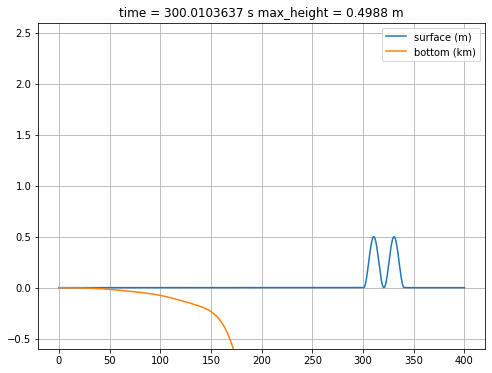

step 10000 completed: t = 504.9828371 s, dt = 0.0504988 s



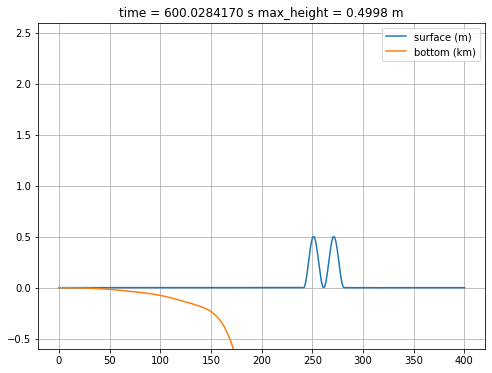

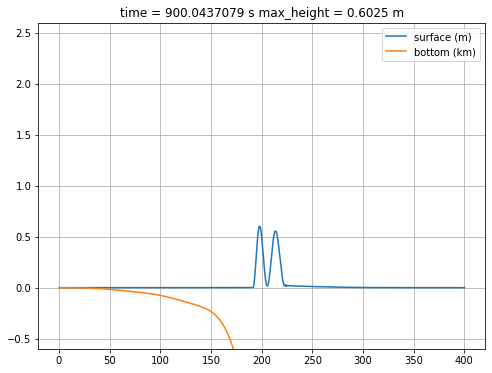

step 20000 completed: t = 1010.0492615 s, dt = 0.0505076 s



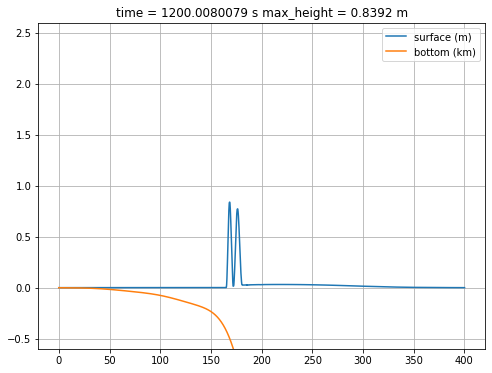

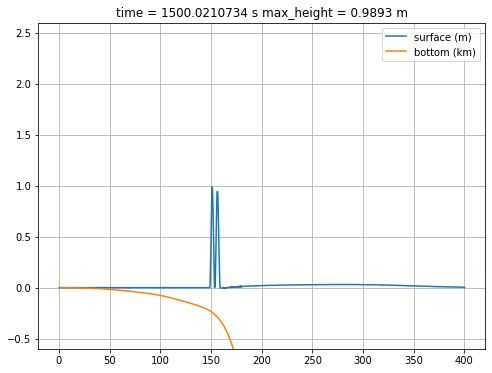

step 30000 completed: t = 1515.1226972 s, dt = 0.0505071 s



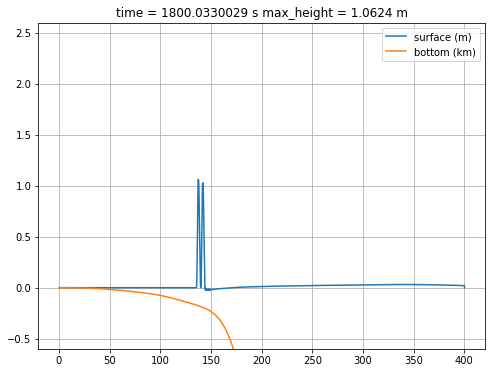

step 40000 completed: t = 2020.1932071 s, dt = 0.0505070 s



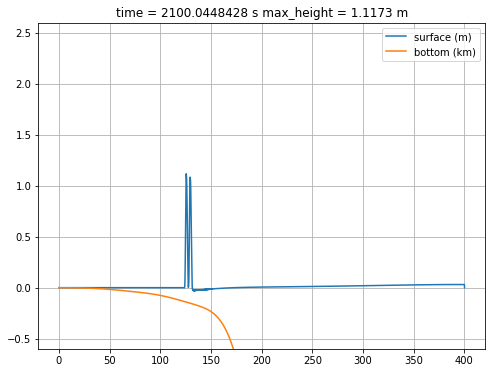

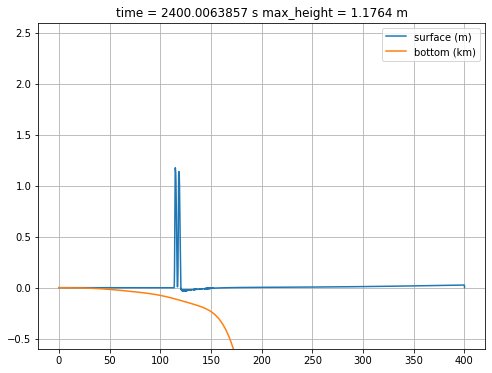

step 50000 completed: t = 2525.2642024 s, dt = 0.0505072 s



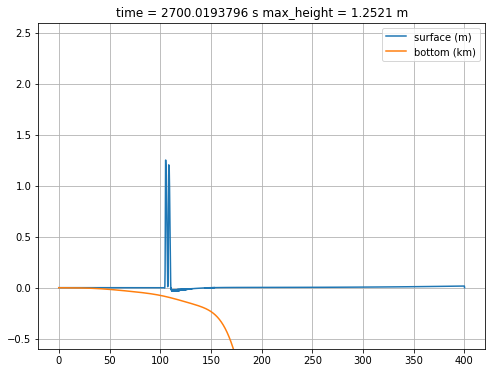

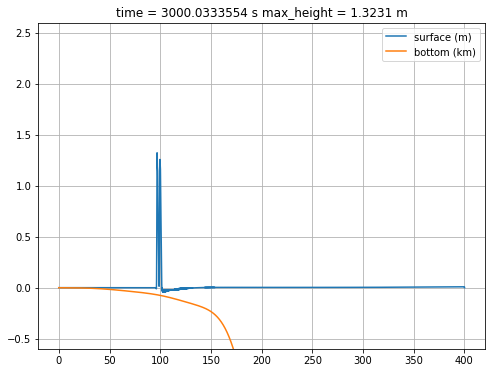

step 60000 completed: t = 3030.3378391 s, dt = 0.0505075 s



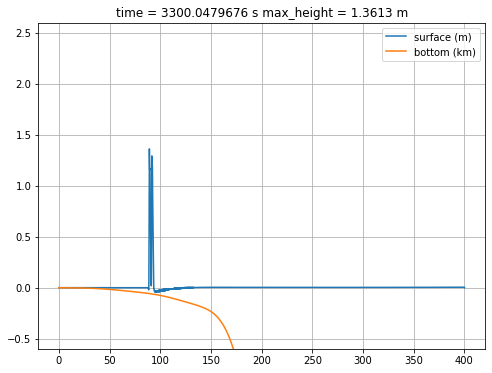

step 70000 completed: t = 3535.4131936 s, dt = 0.0505076 s



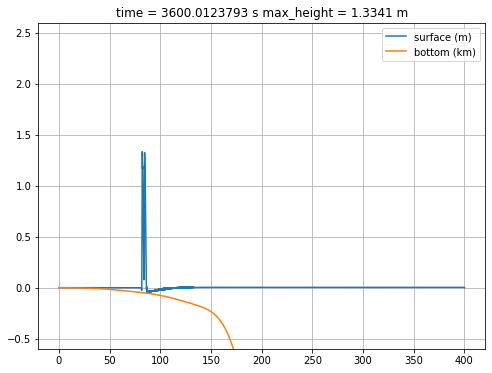

In [806]:
MAX_STEPS = 100000
steps = 0
count = 0
plot_result(q, bGrid, t)
while t <= times[-1]:
    # count the steps
    steps = steps + 1
    
    # determine appropriate timestep
    dt = CFL * dx / np.amax(np.abs(q[1][0,0]) + (g * q[0][0,0]) ** 0.5)
    # tell whether to take a snapshot
    if t + dt >= times[count]:
        take_snapshot = True
        count = count + 1
    else:
        take_snapshot = False
    # advect
    q, t = advect_1step(x, q, bGrid, g, t, dt, bc)
    # take snapshots
    if take_snapshot:
        plot_result(q, bGrid, t)
        
    # report every 10000 steps
    if steps % 10000 == 0:
        print('step %d completed: t = %.7f s, dt = %.7f s\n' % (steps, t, dt))
        
    if steps >= MAX_STEPS:
        print('The number of steps reach the maximum limit. Exit.\n')
        break

In [803]:
def plot_result(q, bGrid, t):
    plt.plot(q[0].get_grid(), 1000*(q[0]+bGrid).get_value(), label = 'surface (m)')
    plt.plot(q[0].get_grid(), bGrid.get_value(), label = 'bottom (km)')
    #plt.plot(q[1].get_grid(), q[1].get_value(), label = 'speed')
    #plt.plot(q[0].get_grid(), np.sqrt(g * q[0].get_value()), label = 'c')
    #plt.plot(q[1].get_grid(), (q[0]*q[1]).get_value(), label = 'momentum')
    plt.ylim((-0.6,2.6))
    #plt.xlim((19.5,39.5))
    plt.grid()
    plt.legend()
    plt.title('time = %.7f s max_height = %.4f m' % (t, np.amax(1000*(q[0]+bGrid).get_value())))
    plt.show()

In [788]:
steps

14041

In [ ]:
'''
Representation

_bGrid      bathymetry
_hGrid      water depth (from bottom to surface)
_uGrid      water flow speed
_g          gravitational acceleration
_bc         boundary conditions

'''
class WaterWaveSim(object):
    def __init__(self):
        pass
    
    def simulate(self):
        pass
    
    def _advect_1step(self):
        pass


In [ ]:
'''
Workflow

# define grid points
xmin = 0
xmax = 100
N = 100
x = np.linspace(xmin, xmax, N+1)
x = (x[:-1] + x[1:]) / 2

# bathymetry
b = somefunction(x)

# initial water surface
s = someotherfunction(x)

# initial speed
u = anotherfunction(x)

# boundary condition
bc = 'non-reflecting'

# gravity acceleration 
g = 9.8

# initialize WaterWaveSim object
ocean = WaterWaveSim(x, b, s, u, g, bc)

# Alternatively, it can be initialized from an input file
ocean = WaterWaveSim('directory/filename')

CFL = 0.1

# preventing the simulation to run eternally when dt is too small
MAX_STEPS = 100000

output_directory = './output/'

ocean.simulate(CFL, MAX_STEPS, times, output_directory)
'''